# Бейзлайн - cv2
Здесь мы смотрим на то как получается заденойзнить с помощью cv2 не используя нейросети, чтобы получить примерное представление о получемом качестве

## Метрики

В качестве метрик будем использовать предложенные в
[этой статье](https://vciba.springeropen.com/articles/10.1186/s42492-019-0016-7)

![](../../docs/figures/denoise_metrics.png)



In [85]:
DATA_PATH = "../../data"
COMPETITION_FOLDER = "denoise"
FULL_RAW_DATA_PATH = f"{DATA_PATH}/raw/{COMPETITION_FOLDER}"
FULL_FINAL_DATA_PATH = f"{DATA_PATH}/final/{COMPETITION_FOLDER}"

In [86]:
import cv2
import numpy as np
from tqdm import tqdm

In [87]:
# to load the arrays
noisy_img_array = np.load(f'{FULL_FINAL_DATA_PATH}/noisy_img_array.npy', allow_pickle=True)
gt_img_array = np.load(f'{FULL_FINAL_DATA_PATH}/gt_img_array.npy', allow_pickle=True)
print(noisy_img_array.shape)
print(gt_img_array.shape)

(160, 1024, 1024, 3)
(160, 1024, 1024, 3)


In [88]:
# Check if opencv uses cuda
print(cv2.ocl.haveOpenCL())
print(cv2.ocl.useOpenCL())

True
True


In [89]:
# Denoise images using the Non-Local Means Denoising algorithm
def denoise(img):
    # print(img.shape)
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

# Denoise the images, use a progress bar to track progress
denoised = [denoise(img) for img in tqdm(noisy_img_array)]
denoised_img_array = np.array(denoised)

# Save the denoised images
np.save(f'{FULL_FINAL_DATA_PATH}/denoised_cv2_img_array.npy', denoised_img_array)

100%|██████████| 160/160 [03:16<00:00,  1.23s/it]


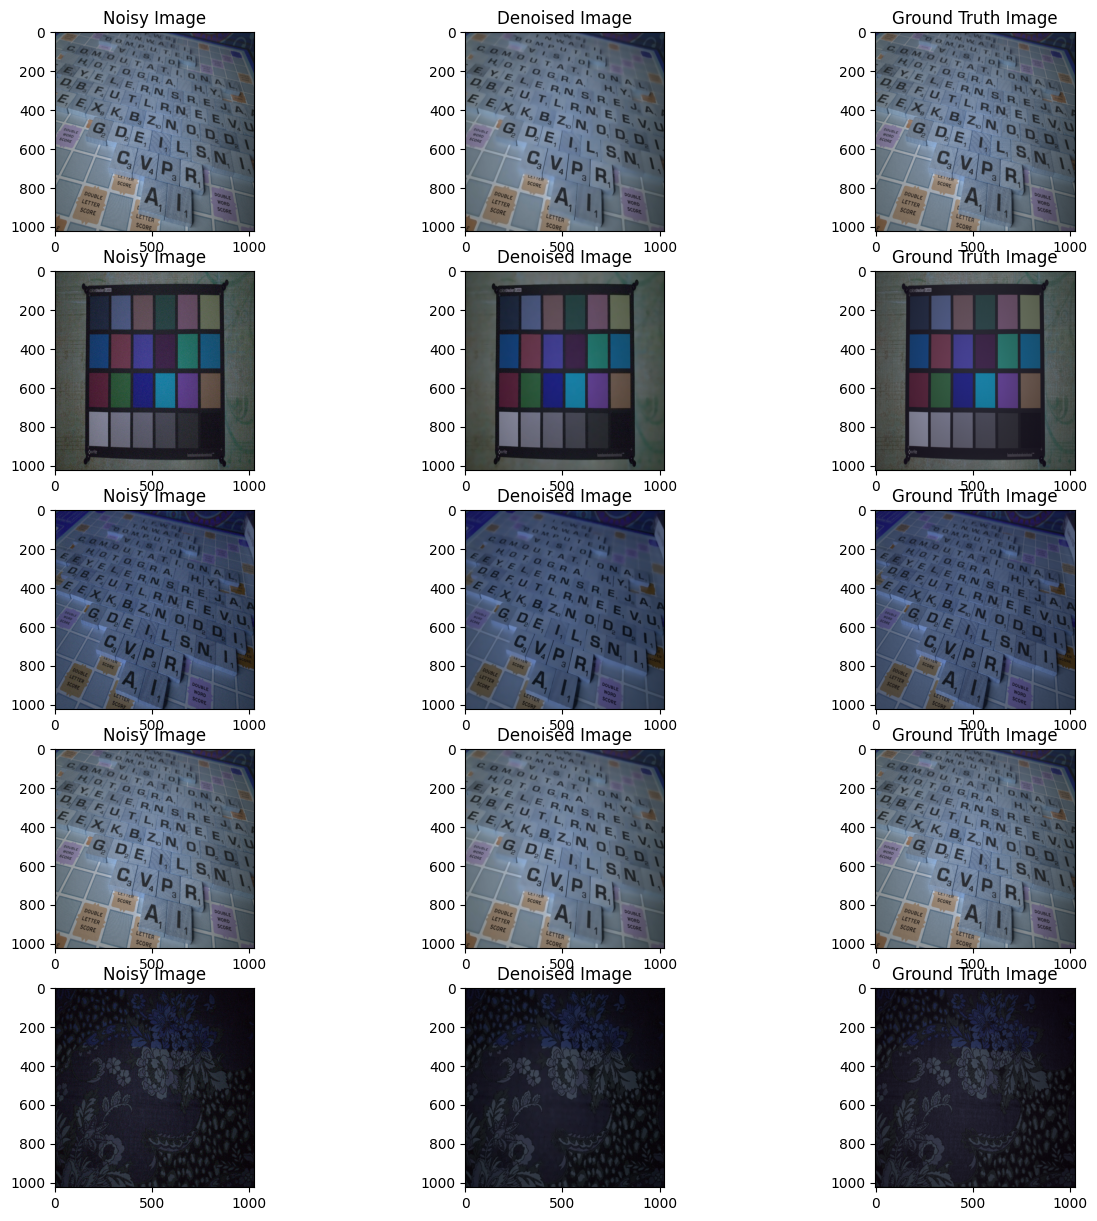

In [90]:
# Load the denoised images
# to load the arrays
noisy_img_array = np.load(f'{FULL_FINAL_DATA_PATH}/noisy_img_array.npy', allow_pickle=True)
gt_img_array = np.load(f'{FULL_FINAL_DATA_PATH}/gt_img_array.npy', allow_pickle=True)
denoised_img_array = np.load(f'{FULL_FINAL_DATA_PATH}/denoised_cv2_img_array.npy', allow_pickle=True)

# Plot the denoised images side by side with the noisy and ground truth images
import matplotlib.pyplot as plt
import random

def plot_denoised_images(noisy_img_array, denoised_img_array, gt_img_array, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))
    for i in range(num_images):
        idx = random.randint(0, noisy_img_array.shape[0])
        axes[i, 0].imshow(noisy_img_array[idx])
        axes[i, 0].set_title("Noisy Image")
        axes[i, 1].imshow(denoised_img_array[idx])
        axes[i, 1].set_title("Denoised Image")
        axes[i, 2].imshow(gt_img_array[idx])
        axes[i, 2].set_title("Ground Truth Image")
    plt.show()

plot_denoised_images(noisy_img_array, denoised_img_array, gt_img_array)


In [91]:
# Посчитать метрику по PSNR и SSIM

# scikit-image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Calculate the PSNR and SSIM for the denoised images
psnr_scores = [psnr(gt_img_array[i], denoised_img_array[i]) for i in tqdm(range(len(gt_img_array)))]

# Fix ssim ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.
# Time-consuming...
ssim_scores = [ssim(gt_img_array[i], denoised_img_array[i], multichannel=True, win_size=3) for i in tqdm(range(len(gt_img_array)))]


100%|██████████| 160/160 [03:06<00:00,  1.17s/it]


In [92]:
psnr_scores[:5]

[37.94930465708357,
 35.14041196501367,
 31.313444512259466,
 37.01086430290823,
 33.14111114775916]

In [93]:
psnr_scores_inf = [psnr(gt_img_array[i], gt_img_array[i]) for i in tqdm(range(len(gt_img_array)))]
print(psnr_scores_inf[:5])


100%|██████████| 160/160 [00:06<00:00, 23.29it/s]

[inf, inf, inf, inf, inf]


In [94]:
# Noisy psnr
psnr_noise_scores = [psnr(gt_img_array[i], noisy_img_array[i]) for i in tqdm(range(len(gt_img_array)))]

100%|██████████| 160/160 [00:06<00:00, 23.11it/s]


In [95]:
inference_time_in_seconds = 60*3+13
def print_perforamnce(what:str, psnr_scores, inference_time_in_seconds, noisy_psnr_scores, ssim_scores=None, output_build=False):
    print(f"="*80)
    print(f"{what} performance")
    print(f"Metrics:")
    print(f"\tPSNR: {np.mean(psnr_scores)} (The more the better)")
    print(f"\tPSNR (noisy): {np.mean(noisy_psnr_scores)} (The more the better)")
    if ssim_scores:
        print(f"\tSSIM: {np.mean(ssim_scores)}")
    print(f"Inference performance:")
    print(f"\tTime per image:\t{(inference_time_in_seconds)/len(psnr_scores)} seconds")
    print(f"\tFPS:\t\t{len(psnr_scores)/inference_time_in_seconds} fps")
    print(f"\tTotal time:\t{inference_time_in_seconds} seconds")
    print(f"\tImages count:\t{len(psnr_scores)}")
    print(f"\tOPENCL ENABLED?:\t{cv2.ocl.useOpenCL()}")
    print(f"="*80)
    if output_build:
        print(f"Build info:\t{cv2.getBuildInformation()}")

print_perforamnce("cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)", psnr_scores, inference_time_in_seconds, psnr_noise_scores, ssim_scores)


cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21) performance
Metrics:
	PSNR: 32.034441250954295 (The more the better)
	PSNR (noisy): 29.221009788431502 (The more the better)
	SSIM: 0.8583738555350905
Inference performance:
	Time per image:	1.20625 seconds
	FPS:		0.8290155440414507 fps
	Total time:	193 seconds
	Images count:	160
	OPENCL ENABLED?:	True


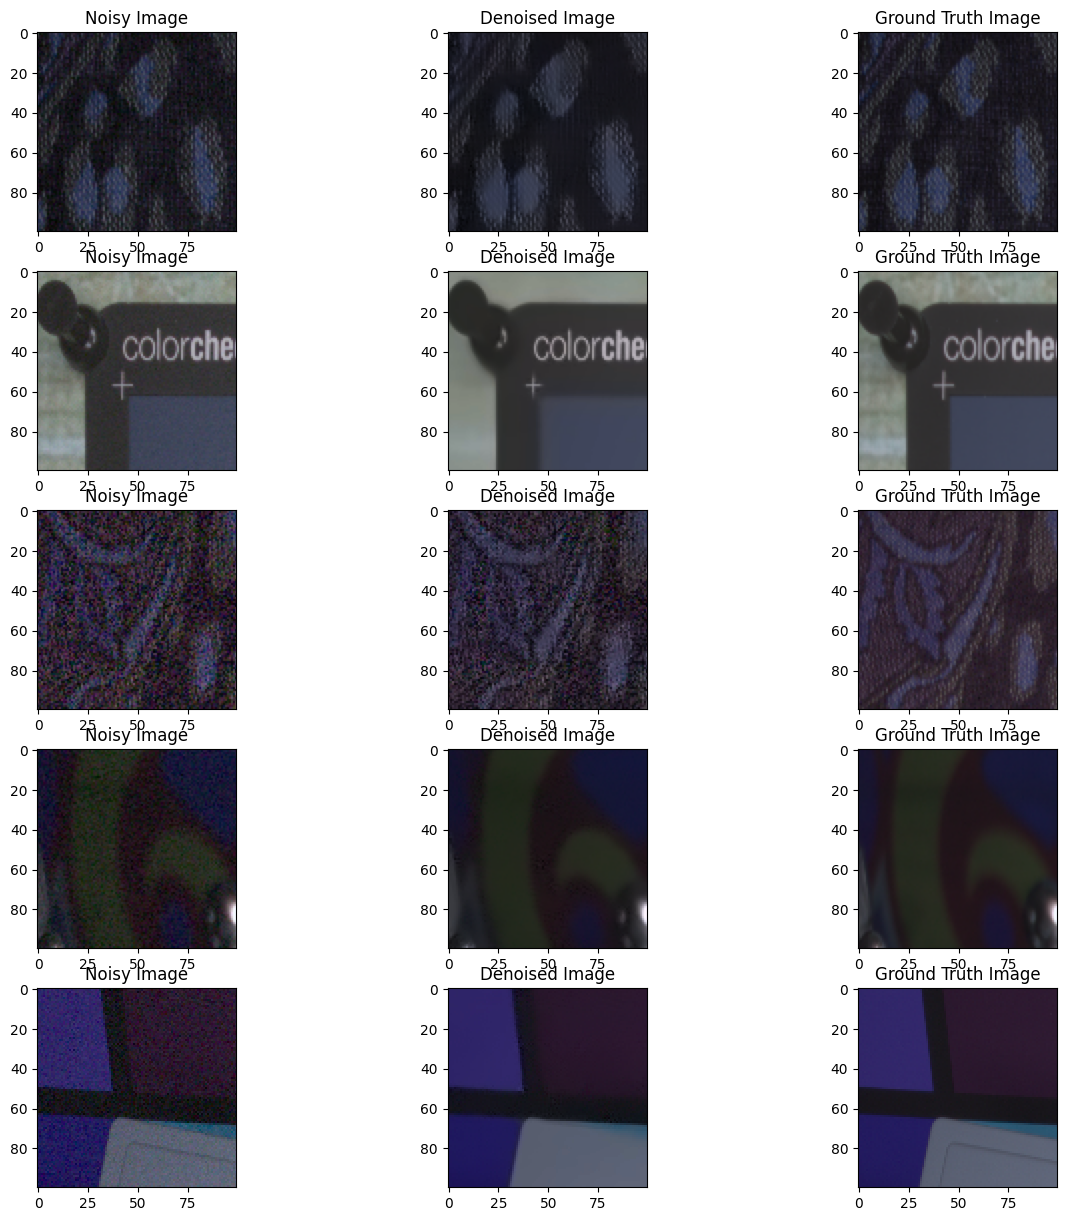

In [96]:
# Zoom in on a small region of the image to see the difference
def plot_denoised_images(noisy_img_array, denoised_img_array, gt_img_array, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))
    for i in range(num_images):
        idx = random.randint(0, noisy_img_array.shape[0])
        axes[i, 0].imshow(noisy_img_array[idx][100:200, 100:200])
        axes[i, 0].set_title("Noisy Image")
        axes[i, 1].imshow(denoised_img_array[idx][100:200, 100:200])
        axes[i, 1].set_title("Denoised Image")
        axes[i, 2].imshow(gt_img_array[idx][100:200, 100:200])
        axes[i, 2].set_title("Ground Truth Image")
    plt.show()

plot_denoised_images(noisy_img_array, denoised_img_array, gt_img_array)